##Setting

In [ ]:
!git clone https://github.com/openaifab/suicide_multiclass.git
#!pip install ckiptagger

Cloning into 'suicide_multiclass'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 36 (delta 3), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (36/36), done.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/mingliu.ttc \
    -O suicide_multiclass/mingliu.ttc
#word embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/cna.cbow.512d.0.txt \
    -O suicide_multiclass/word2vec_model/cna.cbow.512d.0.txt

--2020-07-10 03:20:29--  https://storage.googleapis.com/ai_data_colab2/mingliu.ttc
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32217124 (31M) [application/octet-stream]
Saving to: ‘suicide_multiclass/mingliu.ttc’

suicide_multiclass/ 100%[===================>]  30.72M  58.8MB/s    in 0.5s    

2020-07-10 03:20:31 (58.8 MB/s) - ‘suicide_multiclass/mingliu.ttc’ saved [32217124/32217124]



In [ ]:
#%tensorflow_version 1.X
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
%cd suicide_multiclass
%pwd

/content/suicide_multiclass


'/content/suicide_multiclass'

#Data preprocess

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pickle
from gensim.models import word2vec
import logging
import random

In [ ]:
from OpenFabLibrary import JeibaCutWords
#from OpenFabLibrary import AppendKeywordCheck
from OpenFabLibrary import process_df

##Set parameters

In [ ]:
# HIGH_RISK = 2
# MEDIUM_RISK = 1
# NO_RISK = 0

data_dir = "/".join((".", "data"))
#用記事本打開csv文件，另存為设置編碼為utf-8
data_source = "suicide3_train.csv"

##Load training set data

In [ ]:
data_df = pd.read_csv(data_dir + '/' + data_source, encoding='utf8', delimiter=',')
print(data_df.head())

   ID                                        Description  Class
0   0  最近又把自己蜷縮起來了不想吃不想動好想消失...沒有社會化的我連狗狗都有點社會化不足都兩歲了...      2
1   1  我想已經沒有意義了活著的動力每一天每一天不論在做什麼不論做的好壞一律歸零一切都是爛我整個人生...      2
2   2  因為身心狀況的關係把論文停掉 打算延畢除了指導老師  其他朋友我都沒說昨晚笑笑地跟室友說我買...      2
3   3  可能因為去年流了太多眼淚，又一直失眠拼命讓自己很忙很累才能閉上眼睡著眼睛很少休息所以左眼出了...      2
4   4  到底為什麼週日總會失眠？明明週一要早起為了這個嶄新的開始我最喜歡的禮拜一也應該早睡的可是就是...      2


##斷詞斷句

In [ ]:
# 斷詞處理
train_data_df = JeibaCutWords(data_df, "Description")

# word count
sentence_data = train_data_df.loc[:,'sentence']
train_data_df['word_count'] = sentence_data.str.len() 

print(train_data_df.head())

Building prefix dict from /content/suicide_multiclass/Jeiba/dict.txt.big ...
Dumping model to file cache /tmp/jieba.ucb66ba17c4739edbeb5fb122bb3a9bb9.cache
Loading model cost 1.562 seconds.
Prefix dict has been built successfully.


   id                                           sentence  class  word_count
0   0  [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...      2          93
1   1  [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...      2          39
2   2  [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...      2          58
3   3  [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...      2          28
4   4  [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...      2         144


In [ ]:
#Check if there is empty data
for i in range(len(train_data_df)):
  if len(train_data_df.loc[i,'sentence']) < 3:
    print(i, ":", train_data_df.loc[i,'sentence'])

斷詞後文章長度: 


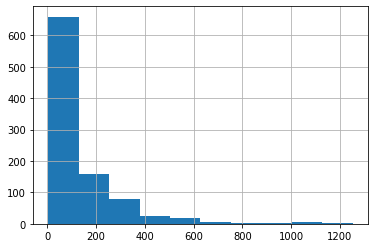

In [ ]:
print("斷詞後文章長度: ")
train_data_df['word_count'].hist()

各風險則數: 
高風險: 121 則
中風險: 181 則
低風險: 657 則
總共: 959 則


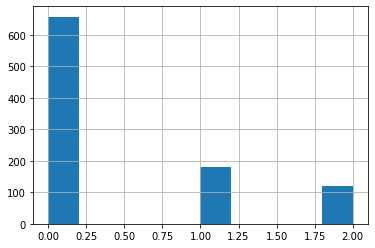

In [ ]:
print("各風險則數: ")
train_data_df['class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

##儲存為pickle格式檔案

In [ ]:
with open(data_dir + '/' + 'train_tokenized', 'wb') as file:
    pickle.dump(train_data_df, file)

#Train model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from OpenFabLibrary import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import copy

In [ ]:
train_data_source = 'train_tokenized'

trunc_type='post'
padding_type='pre' #'pre'
oov_tok = "<OOV>"
#vocab_size = 50000
max_length = 500 # 選取多少詞來當作輸入 Ex:選前面40個詞當作輸入

VALIDATION_RATIO = 0.1

WORD2VEC_DIMENTION = 512 #512 300 128

##Load dataset

In [ ]:
# load article tokenized
with open(data_dir + "/" + train_data_source, 'rb') as file:
    article_df = pickle.load(file)

print(article_df.head(5))

print("#"*100)
print(f"高風險: {article_df[article_df['class'] == 2].shape[0]} 則") 
print(f"中風險: {article_df[article_df['class'] == 1].shape[0]} 則") 
print(f"低風險: {article_df[article_df['class'] == 0].shape[0]} 則")
print(f"總共: {article_df.shape[0]} 則")

   id                                           sentence  class  word_count
0   0  [最近, 蜷縮, 縮起, 縮起來, 動, 消失, 社會, 社會化, 狗狗, 有點, 社會, ...      2          93
1   1  [有意, 意義, 動力, 好壞, 歸零, 一切都是, 爛, 整個, 人生, 最差, 一次, ...      2          39
2   2  [身心, 狀況, 關係, 論文, 停掉,  , 打算, 延, 畢, 指導, 指導老師, 老師...      2          58
3   3  [去年, 流, 太多, 多眼, 眼淚, 失眠, 拼命, 很忙, 累, 閉上眼, 上眼, 睡,...      2          28
4   4  [總會, 失眠, 明明, 一要, 早起, 嶄新, 最, 禮拜, 應該, 早睡, 睡, 感冒,...      2         144
####################################################################################################
高風險: 121 則
中風險: 181 則
低風險: 657 則
總共: 959 則


##Load danger words

In [ ]:
# load article tokenized
with open(data_dir + "/" + 'danger_words', 'rb') as file:
    danger_words = pickle.load(file)
print(danger_words)

['不太想', '自殺', '方法', '不留', '留戀', '世界', '厭世', '規劃', '傷害', '絕望', '命', '網友', '救起', '手腕', '傷痕', '鬼門', '鬼門關', '救命', '思', '覺', '失調', '失調症', '幻聽', '餓死', '想死', '棺材', '放棄', '人生', '陰陽', '兩極', '想', '離開', '死路', '拯救', '死去', '屍體', '墳墓', '死', '不遠', '死法']


##Load pre-trained embeddings

### Kevin

In [ ]:
w2v = word2vec.Word2Vec.load('word2vec_model/zh.bin')
word2id = {k:i for i, k in enumerate(w2v.wv.vocab.keys())}
id2word = {i:k for k, i in word2id.items()}
#print(word2id)
word2id_len = len(word2id)
print('word2id_len:', word2id_len)
print('the last word is:', id2word[word2id_len-1])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


word2id_len: 50101
the last word is: 戰期間


### 科技大擂台
https://github.com/ysj-sp/jin-jin-ti-generator/blob/master/training.py  
https://fgc.stpi.narl.org.tw/activity/videoDetail/4b1141305ddf5522015de5479f4701b1

In [ ]:
# Get word vector
dim = 0
word_vecs = {}
with open('word2vec_model/cna.cbow.512d.0.txt') as f:
    for line in f:
        tokens = line.strip().split()

        if len(tokens) == 2:
            dim = int(tokens[1])
            continue

        word = tokens[0]
        vec = np.array([float(t) for t in tokens[1:]])
        word_vecs[word] = vec

word2id = {k:i for i, k in enumerate(word_vecs.keys())}
id2word = {i:k for k, i in word2id.items()}

##Data augmentation utils

In [ ]:
#random deletion
def rd(sentence, danger_words):
  """
  input sentence: list of words
  output temp_s: processed list of words
  """
  temp_s = copy.deepcopy(sentence)

  itbr = random.randint(0, len(temp_s) -1) #index to be removed
  while temp_s[itbr] in danger_words: #don't delete danger word
    itbr = random.randint(0, len(temp_s) -1) #get index to be removed again

  temp_s.pop(itbr)
  return temp_s

#random swap
def rs(sentence):
  """
  input sentence: list of words
  output temp_s: processed list of words
  """
  temp_s = copy.deepcopy(sentence)

  i1 = random.randint(0, len(temp_s) -1)
  i2 = random.randint(0, len(temp_s) -1)
  # while i2 == i1:
  #   i2 = random.randint(0, len(temp_s) -1)

  temp_s[i1] , temp_s[i2] = temp_s[i2] , temp_s[i1]
  return temp_s

#random insertion
def ri(sentence, danger_words, id2word):
  """
  input sentence: list of words
  output temp_s: processed list of words
  """
  temp_s = copy.deepcopy(sentence)
  
  i1 = random.randint(0, len(id2word) -1)
  while id2word[i1] in danger_words: #don't insert danger word
    i1 = random.randint(0, len(id2word) -1) # get another word because the chosen one was in the danger word list
  
  temp_s.insert(random.randint(0, len(temp_s) -1), id2word[i1])
  return temp_s

In [ ]:
#test the utils
test = article_df.loc[0,'sentence']
print(test)
print(rd(test, danger_words))
print(rs(test))
print(ri(test, danger_words, id2word))

['最近', '蜷縮', '縮起', '縮起來', '動', '消失', '社會', '社會化', '狗狗', '有點', '社會', '社會化', '不足', '兩歲', '錯', '獸醫', '狗狗', '天生', '生就', '膽小', '小可', '一定', '錯', '窩', '腳', '睡覺', '爸媽', '幸福', '對不起', '散步', '影片', '教學', '散步', '站', '室外', '可怕', '前男友', '男友', '陪', '站', '室外', '呼吸', '很困', '困難', '狗狗', '走', '幾步', '回家', '無助', '好想哭', '僵持', '路上', '不行', '能用', '拖', '只好', '回家', '辦不到', '不到', '害', '狗狗', '沒用', '嗚嗚', '有成', '成功', '帶去', '打預防針', '預防', '預防針', 'qwq', '鬆', '一口', '一口氣', '口氣', '好感', '感動', '嗚嗚', '嗚嗚', '嗚嗚', '嗚嗚', '上次', '復', '診', '逃跑', '考慮', '下個月', '換去', '醫院', 'q', '口', 'q', '謝謝', '嗚嗚']
['最近', '蜷縮', '縮起', '縮起來', '動', '消失', '社會', '社會化', '狗狗', '有點', '社會', '社會化', '不足', '兩歲', '錯', '獸醫', '狗狗', '天生', '生就', '膽小', '小可', '一定', '錯', '窩', '腳', '睡覺', '爸媽', '幸福', '對不起', '散步', '影片', '教學', '散步', '站', '室外', '可怕', '前男友', '男友', '陪', '站', '室外', '呼吸', '很困', '困難', '狗狗', '走', '幾步', '回家', '無助', '好想哭', '僵持', '路上', '不行', '能用', '拖', '只好', '回家', '辦不到', '不到', '害', '狗狗', '嗚嗚', '有成', '成功', '帶去', '打預防針', '預防', '預防針', 'qwq', '鬆', '一口', '一口氣', '口氣', '好感', 

##Split into training and validation dataset

In [ ]:
#turn data into list of str and class
corpus = process_df(article_df)
print(f"total cases: {len(corpus)}")
print(corpus)

total cases: 959
[['最近 蜷縮 縮起 縮起來 動 消失 社會 社會化 狗狗 有點 社會 社會化 不足 兩歲 錯 獸醫 狗狗 天生 生就 膽小 小可 一定 錯 窩 腳 睡覺 爸媽 幸福 對不起 散步 影片 教學 散步 站 室外 可怕 前男友 男友 陪 站 室外 呼吸 很困 困難 狗狗 走 幾步 回家 無助 好想哭 僵持 路上 不行 能用 拖 只好 回家 辦不到 不到 害 狗狗 沒用 嗚嗚 有成 成功 帶去 打預防針 預防 預防針 qwq 鬆 一口 一口氣 口氣 好感 感動 嗚嗚 嗚嗚 嗚嗚 嗚嗚 上次 復 診 逃跑 考慮 下個月 換去 醫院 q 口 q 謝謝 嗚嗚', 2], ['有意 意義 動力 好壞 歸零 一切都是 爛 整個 人生 最差 一次 掉 眼淚 忍 好久 身體 外傷 好累 肌肉 能感 感受 受到 疲憊 有時 有時候 逃去 直覺 沒人 愛 自我 價值 被貶 貶低 一無是處 不曉 曉得 愛 悲慘 難過', 2], ['身心 狀況 關係 論文 停掉   打算 延 畢 指導 指導老師 老師     朋友 昨晚 笑笑 笑地 室友 買 很貴 護髮 髮油 看看 問 寫 論文 沒什麼 壓力 笑而不答 幹 娘   天都 想死   天都 痛苦 天都 吃藥 控制   代表 很快 快樂 說話 腦 室友 壓力 閉嘴 管好 難 幹 娘 護髮 髮油 狀況 不可', 2], ['去年 流 太多 多眼 眼淚 失眠 拼命 很忙 累 閉上眼 上眼 睡 眼睛 休息 左眼 問題 醫生 實在 想出 出門 拖 天會 瞎 反正 右眼 剩 夠 夠', 2], ['總會 失眠 明明 一要 早起 嶄新 最 禮拜 應該 早睡 睡 感冒 感冒藥 副作用 作用 習慣 不用 真正 面對 返鄉 那種 解離 般的 失實 實感 重 掙扎 何事 無法 面對 母親 話題 稍微 擦 邊邊 超級 努力 壓制 情緒 露出 痛苦 眼淚 多難 試 聊天 開心 至少 開心 夠 忍受 強烈 反噬 心 透出 透出來 刺痛 想像 一下 血液 流動 深深 深深 深深 理解 自殘 有時 有時候 要死 痛 出口 忍耐 想像 回憶 逼 身體 身體 須要 完好 完好無損 無損 身體 痛 方法 像是 拉 筋 像是 小小 小小的 惡習 在手 手指 染 一點點 點點 血 像是 想像 緩解 解痛 方法 像是 聽 吵 音樂 悲傷 音樂 與世隔絕

In [ ]:
sentences_train=[]
labels_train=[]

random.seed(2459)
random.shuffle(corpus)

training_size = int(len(corpus) * (1-VALIDATION_RATIO))

for x in range(training_size):
    sentences_train.append(corpus[x][0])
    labels_train.append(corpus[x][1])

original_len = len(sentences_train)

print(f"training data: {original_len}")

print(sentences_train[:5])
print(labels_train[:5])

training data: 863
['雷 警告 內容 造成 心理 不適 內容 否定 定心 心理 心理治療 治療 心理 心理治療 治療 跟上 技術 進步 病患 心理 心理健康 健康 得到 保障 19 年來 精神 專科 專科醫院 醫院 心理 心理治療 治療 健 保 諮商 衛生 衛生所 諮商 去年 自費 費心 心理 諮商 初診 衛生 衛生所 心理 諮商 商都 遇過 拿出 一份 問卷 測驗 看到 內容 不禁 懷疑 realy 測驗 測出 每個 獨特 生命 歷程 體徵 監測 腦波 儀器 便宜 測驗 方式 客觀 先進 心理 心理治療 治療 治療師 讀書 考試 寫 論文 一路 讀到 碩士 考到 執照 一年 實習 體驗 社會 業界 殘酷 體驗 社會 角落 人面 面對 對生 生活 掙扎 當兵 得到 特殊 待遇 人心 心理 理解 來自 自書 書本 教案 合格 合格證 合格證書 證書 代表 治療 脆弱 病患 監督 監督機制 機制 監督 治療 治療師 一次 諮商 聽 一群 年輕 諮商 師 閑 聊 聊 內容 聽起 一群 人生 玩家 聊 出國 派對 料 我心 心想 50 分鐘 至少 1800 起跳 諮商 費 諮商 師 合格 遇過 諮商 師 不連貫 連貫 一次 打瞌睡 瞌睡 心不在焉 不在 幾次 次之 換 治療 治療師 對得起 起病 病患 辛苦 存錢 諮商 費 利用 不幸 過上 上好 好生 生活 來說 賺錢 執業 以後 幾年 回本 出師 以後 後年 年薪 想到 職業 特有 義務 毀 心智 奪走 生命 細 思 恐 意識 部份 考到 證照 心理 師 病人 搞 更糟 糟糕 有理 理解 心理 心理學 理學 翻開 開診 診斷 統計 手冊 找出 最 接近 套用 公式 類似 資訊 工程 工程師 處理 活生 活生生 生生 生生的 電腦 電腦系統 系統 弄 崩潰 重灌 弄 崩潰 難 重建 記下 一大 一大堆 大堆 心理 心理學 理學 理論 學習 心理 心理學 理學 技巧 問題 過去 曾經 經心 心理 心理治療 治療 折磨 病人 切除 前額 業 手術 國內 心理 心理治療 治療 跟上 整個 心理 心理學 理學 進步 拿到 證照 以後 隔 幾年 布 進修 心理 心理治療 治療 治療師 新手 來說 病人 學習 無法 寫 紙 走過 痛苦 地獄 了解 教授 不理 理解 現實 必成 凱撒 了解 凱撒 觀點 質疑 沒上 上

###Data augmentation for training data

In [ ]:
#random deletion
for j in range(2):
  for i in range(original_len):
    temp_s = sentences_train[i].split(' ')
    temp_s = rd(temp_s, danger_words)
    temp_s = ' '.join(temp_s)
    sentences_train.append(temp_s)

    temp_c = labels_train[i]
    labels_train.append(temp_c)

In [ ]:
#random swap
for j in range(2):
  for i in range(original_len):
    temp_s = sentences_train[i].split(' ')
    temp_s = rs(temp_s)
    temp_s = ' '.join(temp_s)
    sentences_train.append(temp_s)
    
    temp_c = labels_train[i]
    labels_train.append(temp_c)

In [ ]:
#random insertion
for j in range(3):
  for i in range(original_len):
    temp_s = sentences_train[i].split(' ')
    temp_s = ri(temp_s, danger_words, id2word)
    temp_s = ' '.join(temp_s)
    sentences_train.append(temp_s)
    
    temp_c = labels_train[i]
    labels_train.append(temp_c)

In [ ]:
print(f"training data: {len(sentences_train)}")
print(sentences_train[:5])
print(labels_train[:5])

In [ ]:
tokenizer = Tokenizer(oov_token=oov_tok) #num_words = vocab_size
tokenizer.fit_on_texts(sentences_train)

In [ ]:
sentences_val=[]
labels_val=[]
#validation_size = len(corpus) - training_size
for x in range(training_size, len(corpus)):
    sentences_val.append(corpus[x][0])
    labels_val.append(corpus[x][1])

print(f"validation data: {len(sentences_val)}")

print(sentences_val[:5])
print(labels_val[:5])

validation data: 96
['拼命   拼命 追逐 不夠   不夠 愛 相連   累贅     資格 選擇   不值 值得 最怕   離開 開離 離開 回來 傷害 害過   忽略 略過 自作   受 陪伴   不一 一定 定相 相愛 自首   自首 成 切要   需 躲起 躲起來   愛 不可 可愛   呼吸 意義   推 離開 副歌 Come   away   Come   away   with   meNo   more   tears   No   more   fears   with   meCome   away   with   me 帶上 想見 陳 韻 歌 聽 聽 聽 最終 終結 結局   得到 救贖 本來 貼 歌曲 連結   太長 縮 網址 永遠 藉口 理由 大笑   大哭   吃得下 得下   睡 好似 正常   不正 正常 逼 變好   幫', '明天 除夕 思考 是否 問 老公 是否 回 婆家 過年 一下 行 受到 壓力 父母 難 父母 爺爺 難 爺爺 跡 聽 精彩 犧牲 晚上 不快 快樂 很久 很久很久 很久 很多年 多年 不快 快樂 結婚 以來 累積 不快 快樂 存在 是不是 是我太 自私 耶 問 想得到 得到 答案 老公 是否 承受 壓力 精神 折磨 羞辱 可怕 無法 回娘家 娘家 年夜 年夜飯 夜飯 娘家 大家族 家族 閒話 爸媽 沒面子 面子 閒話 尷尬 存在 錯誤 今晚 藥 最後 昨晚 小 OD 睡來 躲過 十全 十全十美 美的 解決 解決方案 方案 最好 解決 解決方案 方案 睡醒 老公 回 婆家 再見 穿 衣服 去逛 剩下 最後 兩 小時 百貨 百貨公司 公司 途中 買 一杯 手搖 杯 百貨 百貨公司 公司 買 飾品 特惠 組 誠 品 買 兩本 兩本書 本書 百貨 百貨公司 公司 提早 打烊 只好 回家 簡單 晚飯 晚點 弟弟 要來 載 一起 機場 妹妹 接機 過年 行程 無法 全部 避免 最 壞 一部 一部分 部分 逃過 心情 平靜 安靜 假日', '過年 妹 聊天 朋友 交換 學期 30 萬 家 不可   沒錢 妹 30 萬難 ？」 生在 窮人 窮人家 真 靠北 交換 30 萬 補習 從小到大 大要 多少錢 交換 托福 福分 分數 補 托福 不用 用錢 可憐   妹 看不起 人生 很爛 有時 有時候 真不 

##Check the tokenizer

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index)
index_word = tokenizer.index_word

print(f'vocab size is: {vocab_size}')
print(word_index)
#print(index_word[4786])

##Sentence to sequence transform

In [ ]:
sequences_train = tokenizer.texts_to_sequences(sentences_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

sequences_val = tokenizer.texts_to_sequences(sentences_val)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)

labels_train = np.array(labels_train)
labels_val = np.array(labels_val)

print(padded_val)
print(labels_val)

print("#"*100)
print("high risk train: ",np.sum(labels_train==2))
print("medium risk train: ",np.sum(labels_train==1))
print("low risk train: ",np.sum(labels_train==0))

print("high risk val: ",np.sum(labels_val==2))
print("medium risk val: ",np.sum(labels_val==1))
print("low risk val: ",np.sum(labels_val==0))

[[   0    0    0 ...  343  926   82]
 [   0    0    0 ...  625  875 1619]
 [   0    0    0 ... 2339   14  115]
 ...
 [   0    0    0 ... 1090  874 3021]
 [   0    0    0 ... 2215 3239 3240]
 [   0    0    0 ...   88   28  174]]
[0 1 0 2 1 0 0 0 2 1 0 1 0 1 2 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 1 0 2 0
 0 1 0 0 0 0 1 2 0 0 0 1 1 2 0 0 0 0 1 2 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1
 0 2 1 0 2 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
####################################################################################################
high risk train:  880
medium risk train:  1256
low risk train:  4768
high risk val:  11
medium risk val:  24
low risk val:  61


##Load pre-trained w2v, create word ID mapping and word vector

### Kevin

In [ ]:
# print("詞向量維度:", w2v.wv.vectors.shape)
# test_word = '自殺'
# print(f"'{test_word}'字詞相似度: ")
# #print(w2v.wv[test_word])
# w2v.wv.most_similar(test_word)

詞向量維度: (50101, 300)
'自殺'字詞相似度: 


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('自盡', 0.7411878108978271),
 ('跳樓', 0.6840500235557556),
 ('殺害', 0.640125036239624),
 ('上吊', 0.6355459690093994),
 ('切腹', 0.6292052268981934),
 ('自縊', 0.6173856258392334),
 ('強暴', 0.6123636364936829),
 ('喪命', 0.602087140083313),
 ('開槍', 0.5979554057121277),
 ('謀殺', 0.5936020612716675)]

In [ ]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word2id:
    embedding_vector = w2v.wv[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(20312, 300)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.2249358  -0.96961224  0.70858282 ... -0.19811729  0.16071561
  -0.15473877]
 ...
 [-0.01067139  0.7045117  -0.49578372 ... -1.48438537  0.03652007
   0.07475682]
 [-0.10619694 -0.76619011 -0.06624056 ...  1.15425074 -0.5042091
  -0.6920805 ]
 [-0.59476322  0.80945081 -0.27164513 ...  0.52438354  0.55610394
  -0.53069061]]


### 科技大擂台

In [ ]:
print("total words in the pre-trained w2v:", len(word_vecs))
print("dimension: ",len(word_vecs['想要']))
print(word_vecs.get('想死', None))

total words in the pre-trained w2v: 158566
dimension:  512
None


In [ ]:
embeddings_matrix = np.zeros((vocab_size + 1, WORD2VEC_DIMENTION)) # +1 because index_word index starts from 1
for word, i in word_index.items():
  if word in word_vecs:
    embedding_vector = word_vecs[word]
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(embeddings_matrix.shape)
print(embeddings_matrix)

(20552, 512)
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [-0.293505  0.676929 -0.694333 ... -0.838017 -1.443087 -1.639135]
 ...
 [ 0.099474 -1.633364 -0.220114 ... -0.734725 -0.203568 -0.289727]
 [ 0.367402  0.334645  0.169352 ...  0.227316 -1.517589 -0.740812]
 [-0.135777  0.167574  0.418026 ...  0.320325 -0.271538  0.112142]]


##Create LSTM model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, WORD2VEC_DIMENTION, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # 64, 32
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),  #6, 8
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 512)          10522624  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 128)          295424    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 51        
Total params: 10,860,355
Trainable params: 337,731
Non-trainable params: 10,522,624
____________________________________

##Set callback and class_weight

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, 
                                             verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_train), labels_train)
print(class_weights)

[0.48266219 1.83227176 2.61515152]


##Train the model

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 20

history = model.fit(padded_train, labels_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_data=(padded_val, labels_val),callbacks=[earlystop]
                    , class_weight={0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}) #, class_weight={0:class_weights[0], 1:class_weights[1], 2:class_weights[2]}
# Save the entire model as a SavedModel.
#model.save('model/suicide_model.h5')

Epoch 1/20
108/108 [==============================] - 42s 393ms/step - loss: 0.7170 - accuracy: 0.6922 - val_loss: 1.2060 - val_accuracy: 0.5208
Epoch 2/20
108/108 [==============================] - 38s 348ms/step - loss: 0.1091 - accuracy: 0.9649 - val_loss: 2.0243 - val_accuracy: 0.5000
Epoch 3/20
108/108 [==============================] - 36s 330ms/step - loss: 0.0315 - accuracy: 0.9884 - val_loss: 2.3524 - val_accuracy: 0.5625
Epoch 4/20
108/108 [==============================] - 35s 321ms/step - loss: 0.0228 - accuracy: 0.9917 - val_loss: 3.0025 - val_accuracy: 0.5208
Epoch 5/20
108/108 [==============================] - 35s 321ms/step - loss: 0.0177 - accuracy: 0.9933 - val_loss: 3.1326 - val_accuracy: 0.5312
Epoch 6/20
108/108 [==============================] - 35s 320ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 3.4743 - val_accuracy: 0.5521
Epoch 7/20
108/108 [==============================] - 34s 319ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 3.8790 - val_ac

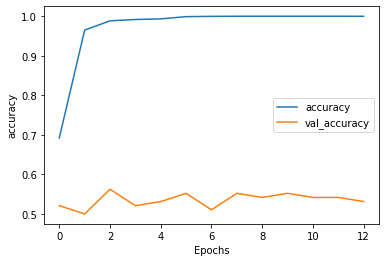

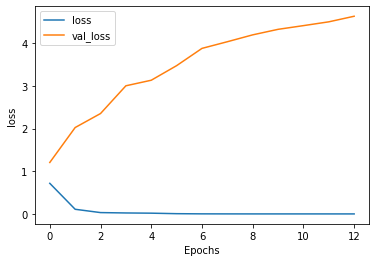

In [ ]:
%matplotlib inline

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#See Validation Confusion Matrix

all predicted result: [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 1 1 1 0 0
 0 0 0 1 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0]
Confusion matrix, without normalization
[[49 10  2]
 [19  4  1]
 [ 9  1  1]]


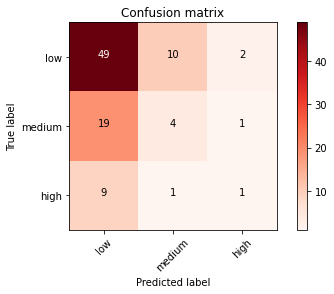

In [ ]:
result = model.predict_classes(padded_val)
print("all predicted result:", result)
cm = confusion_matrix(labels_val, result)
cm_plot_labels = ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

#Test the model

single input  

In [ ]:
# input_text = "習慣了。現在漸漸地變成了一個常態只是後續要處理好自己還是人類部分的情感需求要漸漸地漸漸地習慣讓這部分死去直到我完全的成為了活屍我就成功了對她人最安全的做法就是我完全的不在對方的世界裏我也完全的不說話認識一個人。馬上把她刪好友是對對方最好的做法也是對我最好的做法沒有接觸。沒有期待 沒有傷害快樂是別人的 我什麼都沒有如果＊我＊的這概念也消失了那我就連這段話都感覺不到了這是我的目標成為一具屍體。也不知道賺錢做什麼我覺得世界是一座巨大的墳墓一切都在腐爛我是具有溫度的屍體感覺可以死了。可是又好像跟死了差不多說出這句話竟有種矛盾的感覺反正也離死不遠了--"
# ad_Class = 2
# ad_ID = 0
# ad_Description = input_text

# test_data_df = pd.DataFrame({'ID': [ad_ID], 
#                             'Description':[ad_Description],
#                             'Class':[ad_Class]})
# print(test_data_df)

multiple inputs

In [ ]:
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "suicide_test.csv"
test_data_df = pd.read_csv(data_dir + '/' + test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

   ID                                        Description  Class
0   0                    其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法--      2
1   1  自己覺得不留戀這世界好像影響了身邊的人覺得我厭世規劃的流程還沒走到只能好好地留在這裡好好地吃...      2
2   2  好像又要掉回去掉回去那個深不見底的地方要靠藥物靠傷害自己才能勉強繼續維持生活不過也還好大概只...      2
3   3  前幾天繳稅看到財政部軟體裡面配偶兩字就獃住一下不是無感...是會傷心的--------我總是...      2
4   4  得思覺失調症非我所願幻聽一直臭罵我藥物副作用讓我肌肉沒力不能久站實在是無法工作了在家裡忍受父...      2


In [ ]:
# 斷詞處理
test_df = JeibaCutWords(test_data_df, "Description")
print(test_df)
# 關鍵字檢查
#test_df['keyword_flag'], keywords_list = AppendKeywordCheck(test_df)

#extract all sentences
test_corpus = process_df(test_df)
print(f"total cases: {len(test_corpus)}")
print(test_corpus)

sentences_test=[]
labels_test=[]
for x in range(len(test_corpus)):
    sentences_test.append(test_corpus[x][0])
    labels_test.append(test_corpus[x][1])

print(f"test data: {len(sentences_test)}")

sequences_test = tokenizer.texts_to_sequences(sentences_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(sequences_test)
#print(padded_test)

# probability = model.predict(padded_test)
# print(probability[0])
result = model.predict_classes(padded_test)
print(result)

Building prefix dict from /content/suicide_multiclass/Jeiba/dict.txt.big ...
Loading model from cache /tmp/jieba.ucb66ba17c4739edbeb5fb122bb3a9bb9.cache
Loading model cost 1.108 seconds.
Prefix dict has been built successfully.


      id                                           sentence  class
0      0             [本來, 不太想, 每次, 媽媽, 說完, 話, 辜, 狗, 自殺, 方法]      2
1      1  [覺得, 不留, 留戀, 世界, 好像, 影響, 身邊, 人, 覺得, 厭世, 規劃, 流程...      2
2      2  [好像, 掉, 回去, 去掉, 回去, 深不見底, 不見, 底, 地方, 藥物, 傷害, 勉...      2
3      3  [前, 幾天, 繳稅, 看到, 財政, 財政部, 軟體, 裡面, 配偶, 兩, 字, 獃住,...      2
4      4  [思, 覺, 失調, 失調症, 非我所願, 所願, 幻聽, 一直, 臭罵, 藥物, 副作用,...      2
..   ...                                                ...    ...
113  113  [下雨, 空氣, 濕, 度, 高, 好, 難, 呼吸, 某種, 溫度, 想起, 過去, 某種...      0
114  114  [提, 之後, 三個, 月, 靜靜, 靜靜的, 過去, 承認, 認有, 有時, 有時候, 想...      0
115  115  [確定, 說, 是不是, 篇, 反正, 篇, 講, 不錯, 無聊, 看看, 作者, yehm...      0
116  116  [篇, 勸, 世, 文, 不想, 先, 迴避, 理解, 此時, 生病, 各種因素, 種因, ...      0
117  117  [版主, 主群, 曾, 版規, 版, 發佈, 前, 發文, 提醒, 版, 發表, 言論, 應...      0

[118 rows x 3 columns]
total cases: 118
[['本來 不太想 每次 媽媽 說完 話 辜 狗 自殺 方法', 2], ['覺得 不留 留戀 世界 好像 影響 身邊 人 覺得 厭世 規劃 流程 走到 只能 好好 留在 裡 好好 吃藥 睡覺 上班 一直 循環 醫生 說 理想 辦法 目標 理想 目標 太 浪費 費錢 總 便宜 影響 其他人 辦法 獨立 覺得 

In [ ]:
test_data_df['Predicted'] = result
test_data_df.to_csv(data_dir + '/suicide_test_result.csv', encoding='utf8')

In [ ]:
# if np.argmax(probability) == 2:
#   print("辨識結果: 高風險")
# elif np.argmax(probability) == 1:
#   print("辨識結果: 中風險")
# elif np.argmax(probability) == 0:
#   print("辨識結果: 低風險")

# print("判斷機率: ", probability[0][np.argmax(probability)])
# #print("違規字詞: ", keywords_list)

Confusion matrix, without normalization
[[86  0  0]
 [ 0 15  0]
 [ 0  0 17]]


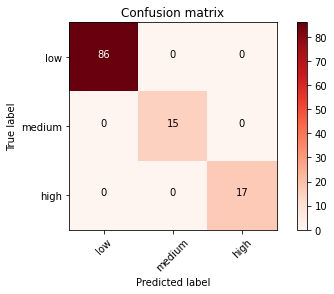

In [ ]:
cm = confusion_matrix(labels_test, result)
cm_plot_labels = ['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

##Backup

In [ ]:
# oringal_len = len(article_df)
# print(oringal_len)
# print(article_df.tail())

# #random deletion
# for i in range(oringal_len):
#   temp_s = rd(article_df.loc[i,'sentence'], danger_words)
#   temp_c = article_df.loc[i,'class']
#   df_new = pd.DataFrame([[temp_s, temp_c]],  columns=['sentence', 'class'])
#   article_df = article_df.append(df_new, ignore_index=True)

# #random swap
# for i in range(oringal_len):
#   temp_s = rs(article_df.loc[i,'sentence'])
#   temp_c = article_df.loc[i,'class']
#   df_new = pd.DataFrame([[temp_s, temp_c]],  columns=['sentence', 'class'])
#   article_df = article_df.append(df_new, ignore_index=True)

# #random insertion
# for i in range(oringal_len):
#   temp_s = ri(article_df.loc[i,'sentence'], danger_words, id2word)
#   temp_c = article_df.loc[i,'class']
#   df_new = pd.DataFrame([[temp_s, temp_c]],  columns=['sentence', 'class'])
#   article_df = article_df.append(df_new, ignore_index=True)

# print(len(article_df))
# print(article_df.tail())
# #article_df.to_csv(data_dir + '/temp.csv', encoding='utf8')
# print('*'*100)
# print("各風險則數: ")
# article_df['class'].hist()

# print(f"高風險: {article_df[article_df['class'] == 2].shape[0]} 則") 
# print(f"中風險: {article_df[article_df['class'] == 1].shape[0]} 則") 
# print(f"低風險: {article_df[article_df['class'] == 0].shape[0]} 則")
# print(f"總共: {article_df.shape[0]} 則")